The dataset contains 36733 instances of 11 sensor measures aggregated over one hour (by means of average or sum) from a gas turbine. 
The Dataset includes gas turbine parameters (such as Turbine Inlet Temperature and Compressor Discharge pressure) in addition to the ambient variables.



Problem statement: predicting turbine energy yield (TEY) using ambient variables as features.



Attribute Information:

The explanations of sensor measurements and their brief statistics are given below.

Variable (Abbr.) Unit Min Max Mean<br>
Ambient temperature (AT) C â€“6.23 37.10 17.71<br>
Ambient pressure (AP) mbar 985.85 1036.56 1013.07<br>
Ambient humidity (AH) (%) 24.08 100.20 77.87<br>
Air filter difference pressure (AFDP) mbar 2.09 7.61 3.93<br>
Gas turbine exhaust pressure (GTEP) mbar 17.70 40.72 25.56<br>
Turbine inlet temperature (TIT) C 1000.85 1100.89 1081.43<br>
Turbine after temperature (TAT) C 511.04 550.61 546.16<br>
Compressor discharge pressure (CDP) mbar 9.85 15.16 12.06<br>
Turbine energy yield (TEY) MWH 100.02 179.50 133.51<br>
Carbon monoxide (CO) mg/m3 0.00 44.10 2.37<br>
Nitrogen oxides (NOx) mg/m3 25.90 119.91 65.29<br>

In [1]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



sns.set_style('darkgrid')

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

In [2]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.utils import np_utils
from keras.constraints import maxnorm
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.wrappers.scikit_learn import KerasRegressor, KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, KFold, RandomizedSearchCV


In [3]:
gas_turbines = pd.read_csv("gas_turbines.csv")
gas_turbines.head()

,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX
0,6.8594,1007.9,96.799,3.5000,19.663,1059.2,550.00,114.70,10.605,3.1547,82.722
1,6.7850,1008.4,97.118,3.4998,19.728,1059.3,550.00,114.72,10.598,3.2363,82.776
2,6.8977,1008.8,95.939,3.4824,19.779,1059.4,549.87,114.71,10.601,3.2012,82.468
3,7.0569,1009.2,95.249,3.4805,19.792,1059.6,549.99,114.72,10.606,3.1923,82.670
4,7.3978,1009.7,95.150,3.4976,19.765,1059.7,549.98,114.72,10.612,3.2484,82.311


In [4]:
gas_turbines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15039 entries, 0 to 15038
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AT      15039 non-null  float64
 1   AP      15039 non-null  float64
 2   AH      15039 non-null  float64
 3   AFDP    15039 non-null  float64
 4   GTEP    15039 non-null  float64
 5   TIT     15039 non-null  float64
 6   TAT     15039 non-null  float64
 7   TEY     15039 non-null  float64
 8   CDP     15039 non-null  float64
 9   CO      15039 non-null  float64
 10  NOX     15039 non-null  float64
dtypes: float64(11)
memory usage: 1.3 MB


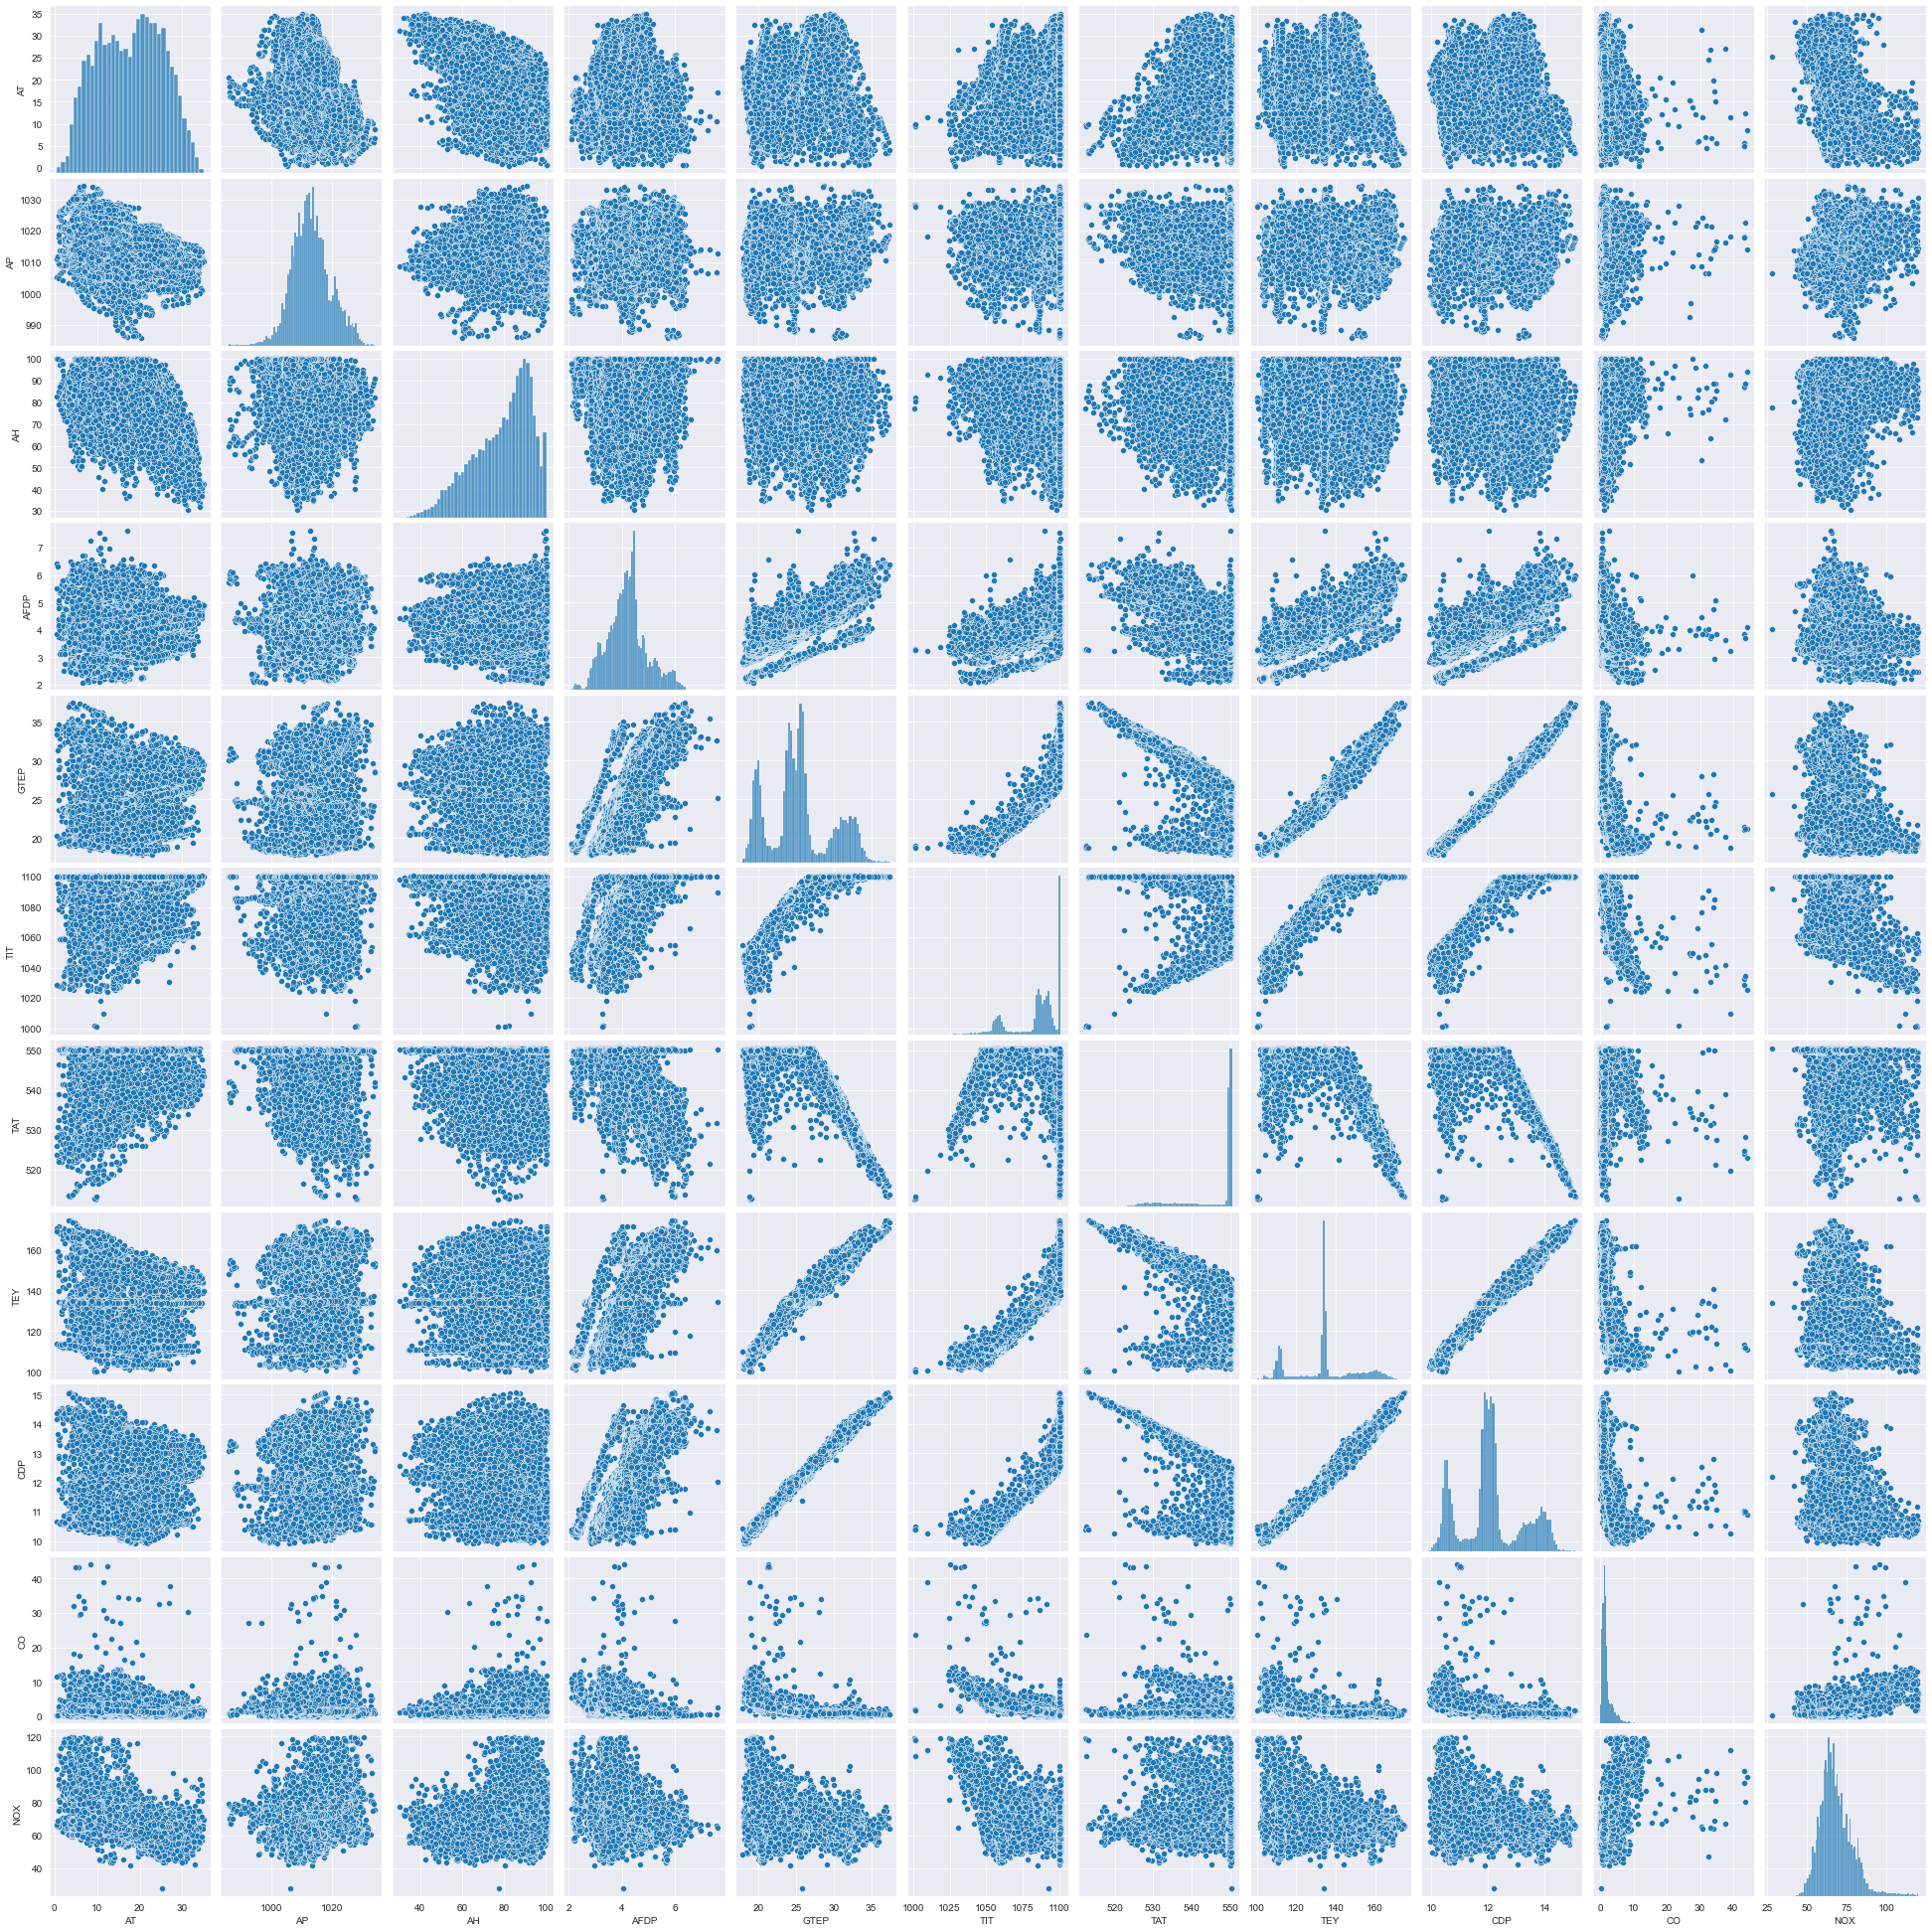

In [5]:
sns.set_style('darkgrid')
sns.pairplot(gas_turbines)

plt.show()

In [6]:
"""color = ["g","y","r", "b","g","y","r", "b","g","y","r"]
for i,j in zip(gas_turbines.columns.values,color):
    f, axes = plt.subplots(figsize=(10,8))
    sns.regplot(x = 'TEY', y = i, data = gas_turbines,color = j, scatter_kws={'alpha':0.3})
    axes.set_xlabel('TEY', fontsize = 14)
    axes.set_ylabel(i, fontsize=14)
    plt.show()"""

'color = ["g","y","r", "b","g","y","r", "b","g","y","r"]\nfor i,j in zip(gas_turbines.columns.values,color):\n    f, axes = plt.subplots(figsize=(10,8))\n    sns.regplot(x = \'TEY\', y = i, data = gas_turbines,color = j, scatter_kws={\'alpha\':0.3})\n    axes.set_xlabel(\'TEY\', fontsize = 14)\n    axes.set_ylabel(i, fontsize=14)\n    plt.show()'

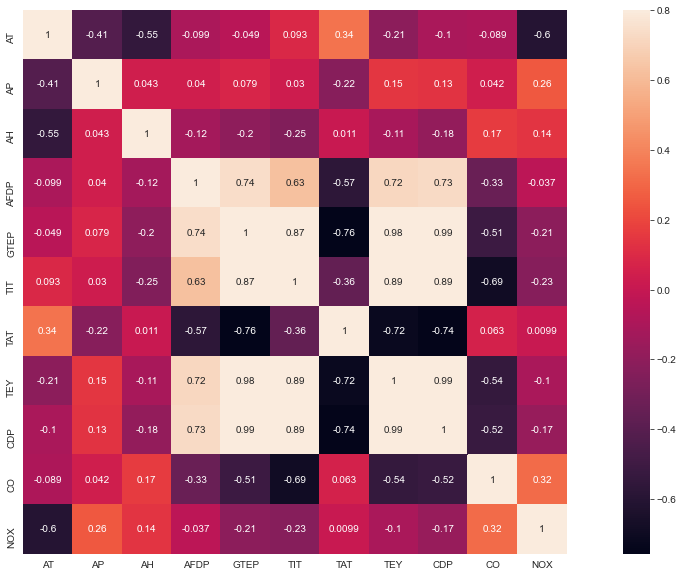

In [7]:
import seaborn as sns
import matplotlib.pyplot as pplt
#correlation matrix
corrmat = gas_turbines.corr()
f, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(corrmat, vmax=.8, square=True, annot=True);

In [8]:
y = gas_turbines[gas_turbines.columns[7]]
X = gas_turbines[['AT', 'AP', 'AH', 'AFDP', 'GTEP', 'TIT', 'TAT', 'CDP', 'CO','NOX']]

Text(0.5, 1.0, 'Correlation with Turbine energy yield \n')

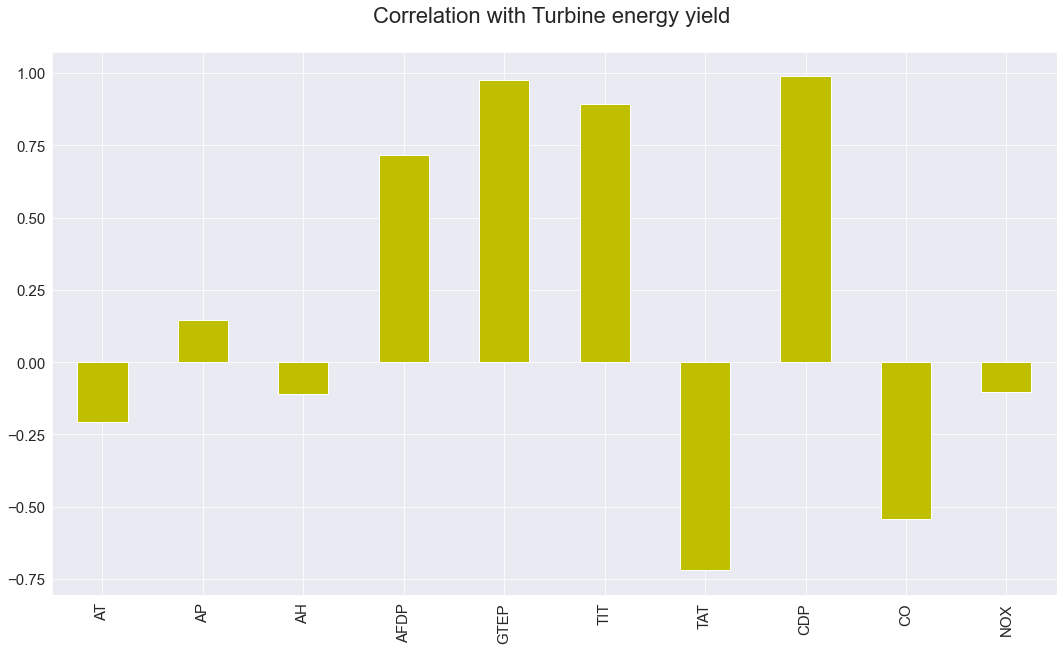

In [9]:
# correlation with TEY

data2 = X.copy()

correlations = data2.corrwith(gas_turbines["TEY"])
correlations = correlations[correlations!=1]
positive_correlations = correlations[correlations >0].sort_values(ascending = False)
negative_correlations =correlations[correlations<0].sort_values(ascending = False)

correlations.plot.bar(
        figsize = (18, 10), 
        fontsize = 15, 
        color = 'y',
        rot = 90, grid = True)
plt.title('Correlation with Turbine energy yield \n',
horizontalalignment="center", fontstyle = "normal", 
fontsize = "22", fontfamily = "sans-serif")

In [10]:
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

In [11]:
#feature selecton

def select_features(X_train, y_train, X_test):
    
    # configure to select all features
    features = SelectKBest(score_func=mutual_info_regression, k='all')
    
    # Relationships from training data
    features.fit(X_train, y_train)
    
    
    
    # transform train data
    X_train_f = features.transform(X_train)
    
    
    
    # transform test data
    X_test_f = features.transform(X_test)
    
    return X_train_f, X_test_f, features


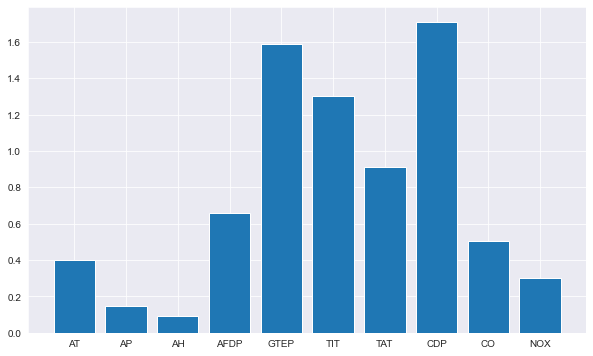

In [12]:
X_train_f, X_test_f, features = select_features(X_train, y_train, X_test)
fig, axes = plt.subplots(figsize=(10, 6))
plt.bar([i for i in range(len(features.scores_))], features.scores_)
axes.set_xticks([0,1,2,3,4,5,6,7,8,9])
axes.set_xticklabels(X.columns.values)
plt.show()

In [13]:
y_copy = gas_turbines["TEY"]
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
y_ = StandardScaler().fit_transform(y_copy.values.reshape(len(y_copy),1))[:,0]


X1 = gas_turbines.drop(['TEY','AT','AP','AH','CO','NOX'], axis = 1)
scaler.fit(X1)


#X_copy = X[['AFDP', 'GTEP', 'TIT', 'TAT', 'CDP']]
features_scaler=scaler.fit_transform(X1)
X_=pd.DataFrame(features_scaler,columns=X[['AFDP', 'GTEP', 'TIT', 'TAT', 'CDP']].columns)
X_.head()

,AFDP,GTEP,TIT,TAT,CDP
0,-0.921232,-1.379101,-1.488376,0.585240,-1.357331
1,-0.921495,-1.363528,-1.482325,0.585240,-1.363676
2,-0.944385,-1.351309,-1.476275,0.568715,-1.360957
3,-0.946884,-1.348194,-1.464173,0.583969,-1.356424
4,-0.924389,-1.354663,-1.458123,0.582698,-1.350985


In [14]:
# Splitting data into test data and train data

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X1, y_, test_size=0.3, random_state=1)

In [15]:

print('Shape of x_train: ', X_train.shape)
print('Shape of x_test: ', X_test.shape)
print('Shape of y_train: ', y_train.shape)
print('Shape of y_test: ', y_test.shape)

Shape of x_train:  (10527, 5)
Shape of x_test:  (4512, 5)
Shape of y_train:  (10527,)
Shape of y_test:  (4512,)


In [16]:
model = Sequential()
model.add(Dense(28, input_dim=5, kernel_initializer='uniform', activation='tanh'))
model.add(Dense(50, kernel_initializer='uniform', activation='tanh'))
model.add(Dense(50, kernel_initializer='uniform', activation='tanh'))
model.add(Dense(1, kernel_initializer='uniform', activation='linear'))

# Compile model
model.compile(loss='mean_squared_error', optimizer='adam', 
              metrics=['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', 'cosine_proximity'])


In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 28)                168       
_________________________________________________________________
dense_1 (Dense)              (None, 50)                1450      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 4,219
Trainable params: 4,219
Non-trainable params: 0
_________________________________________________________________


In [18]:
# Fit the model
history = model.fit(X_train,y_train, epochs=500)

Epoch 1/500
329/329 [==============================] - 1s 1ms/step - loss: 0.6445 - mean_squared_error: 0.6445 - mean_absolute_error: 0.5400 - mean_absolute_percentage_error: 616.8769 - cosine_proximity: 0.2770
Epoch 2/500
329/329 [==============================] - 0s 1ms/step - loss: 0.0842 - mean_squared_error: 0.0842 - mean_absolute_error: 0.2336 - mean_absolute_percentage_error: 1140.4767 - cosine_proximity: 0.5508
Epoch 3/500
329/329 [==============================] - 1s 2ms/step - loss: 0.0682 - mean_squared_error: 0.0682 - mean_absolute_error: 0.2092 - mean_absolute_percentage_error: 1139.7822 - cosine_proximity: 0.5699
Epoch 4/500
329/329 [==============================] - 0s 1ms/step - loss: 0.0717 - mean_squared_error: 0.0717 - mean_absolute_error: 0.2150 - mean_absolute_percentage_error: 1303.7081 - cosine_proximity: 0.5729
Epoch 5/500
329/329 [==============================] - 1s 2ms/step - loss: 0.0811 - mean_squared_error: 0.0811 - mean_absolute_error: 0.2291 - mean_absol

329/329 [==============================] - 1s 2ms/step - loss: 0.0611 - mean_squared_error: 0.0611 - mean_absolute_error: 0.1931 - mean_absolute_percentage_error: 754.0181 - cosine_proximity: 0.5942
Epoch 78/500
329/329 [==============================] - 0s 1ms/step - loss: 0.0554 - mean_squared_error: 0.0554 - mean_absolute_error: 0.1858 - mean_absolute_percentage_error: 597.9717 - cosine_proximity: 0.6002
Epoch 79/500
329/329 [==============================] - 0s 1ms/step - loss: 0.0497 - mean_squared_error: 0.0497 - mean_absolute_error: 0.1732 - mean_absolute_percentage_error: 676.9811 - cosine_proximity: 0.5898
Epoch 80/500
329/329 [==============================] - 1s 2ms/step - loss: 0.0494 - mean_squared_error: 0.0494 - mean_absolute_error: 0.1742 - mean_absolute_percentage_error: 650.7465 - cosine_proximity: 0.5887
Epoch 81/500
329/329 [==============================] - 0s 2ms/step - loss: 0.0625 - mean_squared_error: 0.0625 - mean_absolute_error: 0.1993 - mean_absolute_percent

329/329 [==============================] - 0s 1ms/step - loss: 0.0476 - mean_squared_error: 0.0476 - mean_absolute_error: 0.1709 - mean_absolute_percentage_error: 633.8161 - cosine_proximity: 0.6064
Epoch 152/500
329/329 [==============================] - 1s 2ms/step - loss: 0.0447 - mean_squared_error: 0.0447 - mean_absolute_error: 0.1645 - mean_absolute_percentage_error: 710.8431 - cosine_proximity: 0.6183
Epoch 153/500
329/329 [==============================] - 0s 1ms/step - loss: 0.0702 - mean_squared_error: 0.0702 - mean_absolute_error: 0.2129 - mean_absolute_percentage_error: 966.3699 - cosine_proximity: 0.5624
Epoch 154/500
329/329 [==============================] - 1s 2ms/step - loss: 0.0582 - mean_squared_error: 0.0582 - mean_absolute_error: 0.1903 - mean_absolute_percentage_error: 842.0150 - cosine_proximity: 0.5909
Epoch 155/500
329/329 [==============================] - 1s 2ms/step - loss: 0.0510 - mean_squared_error: 0.0510 - mean_absolute_error: 0.1770 - mean_absolute_per

329/329 [==============================] - 1s 2ms/step - loss: 0.0505 - mean_squared_error: 0.0505 - mean_absolute_error: 0.1759 - mean_absolute_percentage_error: 961.7835 - cosine_proximity: 0.6101
Epoch 228/500
329/329 [==============================] - 0s 2ms/step - loss: 0.0513 - mean_squared_error: 0.0513 - mean_absolute_error: 0.1771 - mean_absolute_percentage_error: 692.0811 - cosine_proximity: 0.6145
Epoch 229/500
329/329 [==============================] - 0s 1ms/step - loss: 0.0465 - mean_squared_error: 0.0465 - mean_absolute_error: 0.1678 - mean_absolute_percentage_error: 606.9306 - cosine_proximity: 0.5900
Epoch 230/500
329/329 [==============================] - 0s 1ms/step - loss: 0.0512 - mean_squared_error: 0.0512 - mean_absolute_error: 0.1789 - mean_absolute_percentage_error: 664.2273 - cosine_proximity: 0.5920
Epoch 231/500
329/329 [==============================] - 1s 2ms/step - loss: 0.0562 - mean_squared_error: 0.0562 - mean_absolute_error: 0.1861 - mean_absolute_per

329/329 [==============================] - 1s 2ms/step - loss: 0.0557 - mean_squared_error: 0.0557 - mean_absolute_error: 0.1836 - mean_absolute_percentage_error: 702.3621 - cosine_proximity: 0.5930
Epoch 303/500
329/329 [==============================] - 1s 2ms/step - loss: 0.0562 - mean_squared_error: 0.0562 - mean_absolute_error: 0.1867 - mean_absolute_percentage_error: 819.7721 - cosine_proximity: 0.5873
Epoch 304/500
329/329 [==============================] - 1s 2ms/step - loss: 0.0593 - mean_squared_error: 0.0593 - mean_absolute_error: 0.1881 - mean_absolute_percentage_error: 801.2378 - cosine_proximity: 0.6133
Epoch 305/500
329/329 [==============================] - 1s 2ms/step - loss: 0.0485 - mean_squared_error: 0.0485 - mean_absolute_error: 0.1703 - mean_absolute_percentage_error: 600.9919 - cosine_proximity: 0.6182
Epoch 306/500
329/329 [==============================] - 0s 1ms/step - loss: 0.0525 - mean_squared_error: 0.0525 - mean_absolute_error: 0.1800 - mean_absolute_per

329/329 [==============================] - 1s 2ms/step - loss: 0.0511 - mean_squared_error: 0.0511 - mean_absolute_error: 0.1745 - mean_absolute_percentage_error: 624.9611 - cosine_proximity: 0.5982
Epoch 379/500
329/329 [==============================] - 1s 2ms/step - loss: 0.0588 - mean_squared_error: 0.0588 - mean_absolute_error: 0.1912 - mean_absolute_percentage_error: 783.6014 - cosine_proximity: 0.5834
Epoch 380/500
329/329 [==============================] - 0s 1ms/step - loss: 0.0570 - mean_squared_error: 0.0570 - mean_absolute_error: 0.1880 - mean_absolute_percentage_error: 785.9511 - cosine_proximity: 0.5913
Epoch 381/500
329/329 [==============================] - 0s 1ms/step - loss: 0.0484 - mean_squared_error: 0.0484 - mean_absolute_error: 0.1692 - mean_absolute_percentage_error: 548.0134 - cosine_proximity: 0.6169
Epoch 382/500
329/329 [==============================] - 0s 1ms/step - loss: 0.0640 - mean_squared_error: 0.0640 - mean_absolute_error: 0.1998 - mean_absolute_per

329/329 [==============================] - 0s 1ms/step - loss: 0.0513 - mean_squared_error: 0.0513 - mean_absolute_error: 0.1759 - mean_absolute_percentage_error: 607.1370 - cosine_proximity: 0.5902
Epoch 454/500
329/329 [==============================] - 1s 2ms/step - loss: 0.0319 - mean_squared_error: 0.0319 - mean_absolute_error: 0.1345 - mean_absolute_percentage_error: 449.0384 - cosine_proximity: 0.6121
Epoch 455/500
329/329 [==============================] - 0s 1ms/step - loss: 0.0368 - mean_squared_error: 0.0368 - mean_absolute_error: 0.1474 - mean_absolute_percentage_error: 653.6587 - cosine_proximity: 0.6055
Epoch 456/500
329/329 [==============================] - 0s 1ms/step - loss: 0.0350 - mean_squared_error: 0.0350 - mean_absolute_error: 0.1424 - mean_absolute_percentage_error: 565.1678 - cosine_proximity: 0.6078
Epoch 457/500
329/329 [==============================] - 0s 1ms/step - loss: 0.0427 - mean_squared_error: 0.0427 - mean_absolute_error: 0.1544 - mean_absolute_per

In [19]:
# model evaluation
scores = model.evaluate(X_test, y_test)
print((model.metrics_names[1]))

141/141 [==============================] - 1s 1ms/step - loss: 0.0299 - mean_squared_error: 0.0299 - mean_absolute_error: 0.1292 - mean_absolute_percentage_error: 372.8955 - cosine_proximity: 0.7110
mean_squared_error


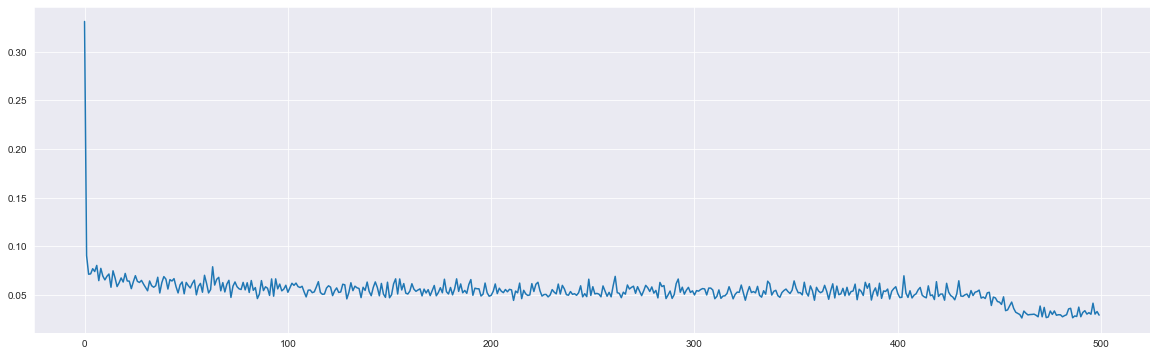

In [20]:
fig, axes = plt.subplots(figsize=(20, 6))
# plot metrics
plt.plot(history.history['mean_squared_error'])
"""plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['mean_absolute_percentage_error'])
plt.plot(history.history['cosine_proximity'])
"""
plt.show()

In [21]:
y2 = gas_turbines["TEY"]
data_c = gas_turbines.copy()
X2 = data_c.drop(['TEY','AT','AP','AH','CO','NOX'], axis = 1)

# Scaling all the features
scaler.fit(X2)
y2_ = StandardScaler().fit_transform(y2.values.reshape(len(y2),1))[:,0]



scaled_features=scaler.transform(X2)
data_head=pd.DataFrame(scaled_features,columns=X2.columns)
data_head.head()

,AFDP,GTEP,TIT,TAT,CDP
0,-0.921232,-1.379101,-1.488376,0.585240,-1.357331
1,-0.921495,-1.363528,-1.482325,0.585240,-1.363676
2,-0.944385,-1.351309,-1.476275,0.568715,-1.360957
3,-0.946884,-1.348194,-1.464173,0.583969,-1.356424
4,-0.924389,-1.354663,-1.458123,0.582698,-1.350985


In [22]:
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam


x_train, x_test, y_train, y_test = train_test_split(X2, gas_turbines["TEY"], test_size=0.3, random_state=42)

In [ ]:

def create_model(learning_rate,dropout_rate,activation_function,init,neuron1,neuron2):
    model = Sequential()
    model.add(Dense(neuron1,input_dim = 5,kernel_initializer = init,activation = activation_function))
    model.add(Dropout(dropout_rate))
    model.add(Dense(neuron2,input_dim = neuron1,kernel_initializer = init,activation = activation_function))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1,activation = 'linear'))
    
    adam=Adam(learning_rate = learning_rate)
    model.compile(loss = 'mean_squared_error',optimizer = adam, metrics = ['mse'])
    return model

# Create the model

model = KerasClassifier(build_fn = create_model,verbose = 0)

# Define the grid search parameters

batch_size = [20,40]
epochs = [100,500]
learning_rate = [0.01,0.1]
dropout_rate = [0.1,0.2]
activation_function = ['softmax','relu','tanh','linear']
init = ['uniform','normal']
neuron1 = [4,8,16]
neuron2 = [2,4,8]

# Make a dictionary of the grid search parameters

param_grids = dict(batch_size = batch_size,epochs = epochs,learning_rate = learning_rate,dropout_rate = dropout_rate,
                   activation_function = activation_function,init = init,neuron1 = neuron1,neuron2 = neuron2)

# Build and fit the GridSearchCV

grid = GridSearchCV(estimator = model,param_grid = param_grids,cv = KFold(),verbose = 10, scoring='neg_mean_squared_error')
grid_result = grid.fit(x_train, y_train)

# Summarize the results
print('Best : {}, using {}'.format(grid_result.best_score_,grid_result.best_params_))

Fitting 5 folds for each of 1152 candidates, totalling 5760 fits
[CV] activation_function=softmax, batch_size=20, dropout_rate=0.1, epochs=100, init=uniform, learning_rate=0.01, neuron1=4, neuron2=2 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  activation_function=softmax, batch_size=20, dropout_rate=0.1, epochs=100, init=uniform, learning_rate=0.01, neuron1=4, neuron2=2, score=-1426.468, total=  30.3s
[CV] activation_function=softmax, batch_size=20, dropout_rate=0.1, epochs=100, init=uniform, learning_rate=0.01, neuron1=4, neuron2=2 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   30.2s remaining:    0.0s


[CV]  activation_function=softmax, batch_size=20, dropout_rate=0.1, epochs=100, init=uniform, learning_rate=0.01, neuron1=4, neuron2=2, score=-1388.876, total=  29.3s
[CV] activation_function=softmax, batch_size=20, dropout_rate=0.1, epochs=100, init=uniform, learning_rate=0.01, neuron1=4, neuron2=2 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   59.6s remaining:    0.0s


[CV]  activation_function=softmax, batch_size=20, dropout_rate=0.1, epochs=100, init=uniform, learning_rate=0.01, neuron1=4, neuron2=2, score=-1350.603, total=  29.7s
[CV] activation_function=softmax, batch_size=20, dropout_rate=0.1, epochs=100, init=uniform, learning_rate=0.01, neuron1=4, neuron2=2 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.5min remaining:    0.0s


[CV]  activation_function=softmax, batch_size=20, dropout_rate=0.1, epochs=100, init=uniform, learning_rate=0.01, neuron1=4, neuron2=2, score=-1412.378, total=  28.8s
[CV] activation_function=softmax, batch_size=20, dropout_rate=0.1, epochs=100, init=uniform, learning_rate=0.01, neuron1=4, neuron2=2 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  2.0min remaining:    0.0s


[CV]  activation_function=softmax, batch_size=20, dropout_rate=0.1, epochs=100, init=uniform, learning_rate=0.01, neuron1=4, neuron2=2, score=-1368.302, total=  27.9s
[CV] activation_function=softmax, batch_size=20, dropout_rate=0.1, epochs=100, init=uniform, learning_rate=0.01, neuron1=4, neuron2=4 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.4min remaining:    0.0s


[CV]  activation_function=softmax, batch_size=20, dropout_rate=0.1, epochs=100, init=uniform, learning_rate=0.01, neuron1=4, neuron2=4, score=-1426.468, total=  29.6s
[CV] activation_function=softmax, batch_size=20, dropout_rate=0.1, epochs=100, init=uniform, learning_rate=0.01, neuron1=4, neuron2=4 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  2.9min remaining:    0.0s


[CV]  activation_function=softmax, batch_size=20, dropout_rate=0.1, epochs=100, init=uniform, learning_rate=0.01, neuron1=4, neuron2=4, score=-1388.876, total=  30.1s
[CV] activation_function=softmax, batch_size=20, dropout_rate=0.1, epochs=100, init=uniform, learning_rate=0.01, neuron1=4, neuron2=4 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  3.4min remaining:    0.0s


[CV]  activation_function=softmax, batch_size=20, dropout_rate=0.1, epochs=100, init=uniform, learning_rate=0.01, neuron1=4, neuron2=4, score=-1350.603, total=  31.3s
[CV] activation_function=softmax, batch_size=20, dropout_rate=0.1, epochs=100, init=uniform, learning_rate=0.01, neuron1=4, neuron2=4 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  4.0min remaining:    0.0s


[CV]  activation_function=softmax, batch_size=20, dropout_rate=0.1, epochs=100, init=uniform, learning_rate=0.01, neuron1=4, neuron2=4, score=-1412.378, total=  30.9s
[CV] activation_function=softmax, batch_size=20, dropout_rate=0.1, epochs=100, init=uniform, learning_rate=0.01, neuron1=4, neuron2=4 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  4.5min remaining:    0.0s


[CV]  activation_function=softmax, batch_size=20, dropout_rate=0.1, epochs=100, init=uniform, learning_rate=0.01, neuron1=4, neuron2=4, score=-1368.302, total=  30.2s
[CV] activation_function=softmax, batch_size=20, dropout_rate=0.1, epochs=100, init=uniform, learning_rate=0.01, neuron1=4, neuron2=8 
[CV]  activation_function=softmax, batch_size=20, dropout_rate=0.1, epochs=100, init=uniform, learning_rate=0.01, neuron1=4, neuron2=8, score=-1426.468, total=  31.2s
[CV] activation_function=softmax, batch_size=20, dropout_rate=0.1, epochs=100, init=uniform, learning_rate=0.01, neuron1=4, neuron2=8 
[CV]  activation_function=softmax, batch_size=20, dropout_rate=0.1, epochs=100, init=uniform, learning_rate=0.01, neuron1=4, neuron2=8, score=-1388.876, total=  30.7s
[CV] activation_function=softmax, batch_size=20, dropout_rate=0.1, epochs=100, init=uniform, learning_rate=0.01, neuron1=4, neuron2=8 
[CV]  activation_function=softmax, batch_size=20, dropout_rate=0.1, epochs=100, init=uniform, 

[CV]  activation_function=softmax, batch_size=20, dropout_rate=0.1, epochs=100, init=uniform, learning_rate=0.01, neuron1=16, neuron2=4, score=-1350.603, total=  28.0s
[CV] activation_function=softmax, batch_size=20, dropout_rate=0.1, epochs=100, init=uniform, learning_rate=0.01, neuron1=16, neuron2=4 
[CV]  activation_function=softmax, batch_size=20, dropout_rate=0.1, epochs=100, init=uniform, learning_rate=0.01, neuron1=16, neuron2=4, score=-1412.378, total=  29.1s
[CV] activation_function=softmax, batch_size=20, dropout_rate=0.1, epochs=100, init=uniform, learning_rate=0.01, neuron1=16, neuron2=4 
[CV]  activation_function=softmax, batch_size=20, dropout_rate=0.1, epochs=100, init=uniform, learning_rate=0.01, neuron1=16, neuron2=4, score=-1368.302, total=  31.4s
[CV] activation_function=softmax, batch_size=20, dropout_rate=0.1, epochs=100, init=uniform, learning_rate=0.01, neuron1=16, neuron2=8 
[CV]  activation_function=softmax, batch_size=20, dropout_rate=0.1, epochs=100, init=uni

[CV]  activation_function=softmax, batch_size=20, dropout_rate=0.1, epochs=100, init=uniform, learning_rate=0.1, neuron1=8, neuron2=4, score=-1426.468, total=  29.2s
[CV] activation_function=softmax, batch_size=20, dropout_rate=0.1, epochs=100, init=uniform, learning_rate=0.1, neuron1=8, neuron2=4 
[CV]  activation_function=softmax, batch_size=20, dropout_rate=0.1, epochs=100, init=uniform, learning_rate=0.1, neuron1=8, neuron2=4, score=-1388.876, total=  28.2s
[CV] activation_function=softmax, batch_size=20, dropout_rate=0.1, epochs=100, init=uniform, learning_rate=0.1, neuron1=8, neuron2=4 
[CV]  activation_function=softmax, batch_size=20, dropout_rate=0.1, epochs=100, init=uniform, learning_rate=0.1, neuron1=8, neuron2=4, score=-1350.603, total=  28.0s
[CV] activation_function=softmax, batch_size=20, dropout_rate=0.1, epochs=100, init=uniform, learning_rate=0.1, neuron1=8, neuron2=4 
[CV]  activation_function=softmax, batch_size=20, dropout_rate=0.1, epochs=100, init=uniform, learni

[CV]  activation_function=softmax, batch_size=20, dropout_rate=0.1, epochs=100, init=normal, learning_rate=0.01, neuron1=4, neuron2=2, score=-1412.378, total=  30.2s
[CV] activation_function=softmax, batch_size=20, dropout_rate=0.1, epochs=100, init=normal, learning_rate=0.01, neuron1=4, neuron2=2 
[CV]  activation_function=softmax, batch_size=20, dropout_rate=0.1, epochs=100, init=normal, learning_rate=0.01, neuron1=4, neuron2=2, score=-1368.302, total=  27.5s
[CV] activation_function=softmax, batch_size=20, dropout_rate=0.1, epochs=100, init=normal, learning_rate=0.01, neuron1=4, neuron2=4 
[CV]  activation_function=softmax, batch_size=20, dropout_rate=0.1, epochs=100, init=normal, learning_rate=0.01, neuron1=4, neuron2=4, score=-1426.468, total=  31.0s
[CV] activation_function=softmax, batch_size=20, dropout_rate=0.1, epochs=100, init=normal, learning_rate=0.01, neuron1=4, neuron2=4 
[CV]  activation_function=softmax, batch_size=20, dropout_rate=0.1, epochs=100, init=normal, learnin

[CV]  activation_function=softmax, batch_size=20, dropout_rate=0.1, epochs=100, init=normal, learning_rate=0.01, neuron1=16, neuron2=2, score=-1388.876, total=  27.8s
[CV] activation_function=softmax, batch_size=20, dropout_rate=0.1, epochs=100, init=normal, learning_rate=0.01, neuron1=16, neuron2=2 
[CV]  activation_function=softmax, batch_size=20, dropout_rate=0.1, epochs=100, init=normal, learning_rate=0.01, neuron1=16, neuron2=2, score=-1350.603, total=  27.3s
[CV] activation_function=softmax, batch_size=20, dropout_rate=0.1, epochs=100, init=normal, learning_rate=0.01, neuron1=16, neuron2=2 
[CV]  activation_function=softmax, batch_size=20, dropout_rate=0.1, epochs=100, init=normal, learning_rate=0.01, neuron1=16, neuron2=2, score=-1412.378, total=  35.1s
[CV] activation_function=softmax, batch_size=20, dropout_rate=0.1, epochs=100, init=normal, learning_rate=0.01, neuron1=16, neuron2=2 
[CV]  activation_function=softmax, batch_size=20, dropout_rate=0.1, epochs=100, init=normal, l

[CV]  activation_function=softmax, batch_size=20, dropout_rate=0.1, epochs=100, init=normal, learning_rate=0.1, neuron1=4, neuron2=8, score=-1368.302, total=  28.6s
[CV] activation_function=softmax, batch_size=20, dropout_rate=0.1, epochs=100, init=normal, learning_rate=0.1, neuron1=8, neuron2=2 
[CV]  activation_function=softmax, batch_size=20, dropout_rate=0.1, epochs=100, init=normal, learning_rate=0.1, neuron1=8, neuron2=2, score=-1426.468, total=  30.9s
[CV] activation_function=softmax, batch_size=20, dropout_rate=0.1, epochs=100, init=normal, learning_rate=0.1, neuron1=8, neuron2=2 
[CV]  activation_function=softmax, batch_size=20, dropout_rate=0.1, epochs=100, init=normal, learning_rate=0.1, neuron1=8, neuron2=2, score=-1388.876, total=  29.0s
[CV] activation_function=softmax, batch_size=20, dropout_rate=0.1, epochs=100, init=normal, learning_rate=0.1, neuron1=8, neuron2=2 
[CV]  activation_function=softmax, batch_size=20, dropout_rate=0.1, epochs=100, init=normal, learning_rate

[CV]  activation_function=softmax, batch_size=20, dropout_rate=0.1, epochs=100, init=normal, learning_rate=0.1, neuron1=16, neuron2=8, score=-1350.603, total=  28.2s
[CV] activation_function=softmax, batch_size=20, dropout_rate=0.1, epochs=100, init=normal, learning_rate=0.1, neuron1=16, neuron2=8 
[CV]  activation_function=softmax, batch_size=20, dropout_rate=0.1, epochs=100, init=normal, learning_rate=0.1, neuron1=16, neuron2=8, score=-1412.378, total=  29.8s
[CV] activation_function=softmax, batch_size=20, dropout_rate=0.1, epochs=100, init=normal, learning_rate=0.1, neuron1=16, neuron2=8 
[CV]  activation_function=softmax, batch_size=20, dropout_rate=0.1, epochs=100, init=normal, learning_rate=0.1, neuron1=16, neuron2=8, score=-1368.302, total=  28.5s
[CV] activation_function=softmax, batch_size=20, dropout_rate=0.1, epochs=500, init=uniform, learning_rate=0.01, neuron1=4, neuron2=2 
[CV]  activation_function=softmax, batch_size=20, dropout_rate=0.1, epochs=500, init=uniform, learn

[CV]  activation_function=softmax, batch_size=20, dropout_rate=0.1, epochs=500, init=uniform, learning_rate=0.01, neuron1=8, neuron2=8, score=-1426.468, total= 2.5min
[CV] activation_function=softmax, batch_size=20, dropout_rate=0.1, epochs=500, init=uniform, learning_rate=0.01, neuron1=8, neuron2=8 
[CV]  activation_function=softmax, batch_size=20, dropout_rate=0.1, epochs=500, init=uniform, learning_rate=0.01, neuron1=8, neuron2=8, score=-1388.876, total= 2.3min
[CV] activation_function=softmax, batch_size=20, dropout_rate=0.1, epochs=500, init=uniform, learning_rate=0.01, neuron1=8, neuron2=8 
[CV]  activation_function=softmax, batch_size=20, dropout_rate=0.1, epochs=500, init=uniform, learning_rate=0.01, neuron1=8, neuron2=8, score=-1350.603, total= 2.3min
[CV] activation_function=softmax, batch_size=20, dropout_rate=0.1, epochs=500, init=uniform, learning_rate=0.01, neuron1=8, neuron2=8 
[CV]  activation_function=softmax, batch_size=20, dropout_rate=0.1, epochs=500, init=uniform, 

[CV]  activation_function=softmax, batch_size=20, dropout_rate=0.1, epochs=500, init=uniform, learning_rate=0.1, neuron1=4, neuron2=4, score=-1412.378, total= 2.4min
[CV] activation_function=softmax, batch_size=20, dropout_rate=0.1, epochs=500, init=uniform, learning_rate=0.1, neuron1=4, neuron2=4 
[CV]  activation_function=softmax, batch_size=20, dropout_rate=0.1, epochs=500, init=uniform, learning_rate=0.1, neuron1=4, neuron2=4, score=-1368.302, total= 2.5min
[CV] activation_function=softmax, batch_size=20, dropout_rate=0.1, epochs=500, init=uniform, learning_rate=0.1, neuron1=4, neuron2=8 
[CV]  activation_function=softmax, batch_size=20, dropout_rate=0.1, epochs=500, init=uniform, learning_rate=0.1, neuron1=4, neuron2=8, score=-1426.468, total= 2.3min
[CV] activation_function=softmax, batch_size=20, dropout_rate=0.1, epochs=500, init=uniform, learning_rate=0.1, neuron1=4, neuron2=8 
[CV]  activation_function=softmax, batch_size=20, dropout_rate=0.1, epochs=500, init=uniform, learni

[CV]  activation_function=softmax, batch_size=20, dropout_rate=0.1, epochs=500, init=uniform, learning_rate=0.1, neuron1=16, neuron2=4, score=-1388.876, total= 2.3min
[CV] activation_function=softmax, batch_size=20, dropout_rate=0.1, epochs=500, init=uniform, learning_rate=0.1, neuron1=16, neuron2=4 
[CV]  activation_function=softmax, batch_size=20, dropout_rate=0.1, epochs=500, init=uniform, learning_rate=0.1, neuron1=16, neuron2=4, score=-1350.603, total= 2.5min
[CV] activation_function=softmax, batch_size=20, dropout_rate=0.1, epochs=500, init=uniform, learning_rate=0.1, neuron1=16, neuron2=4 
[CV]  activation_function=softmax, batch_size=20, dropout_rate=0.1, epochs=500, init=uniform, learning_rate=0.1, neuron1=16, neuron2=4, score=-1412.378, total= 2.4min
[CV] activation_function=softmax, batch_size=20, dropout_rate=0.1, epochs=500, init=uniform, learning_rate=0.1, neuron1=16, neuron2=4 
[CV]  activation_function=softmax, batch_size=20, dropout_rate=0.1, epochs=500, init=uniform, 

[CV]  activation_function=softmax, batch_size=20, dropout_rate=0.1, epochs=500, init=normal, learning_rate=0.01, neuron1=8, neuron2=2, score=-1368.302, total= 2.4min
[CV] activation_function=softmax, batch_size=20, dropout_rate=0.1, epochs=500, init=normal, learning_rate=0.01, neuron1=8, neuron2=4 
[CV]  activation_function=softmax, batch_size=20, dropout_rate=0.1, epochs=500, init=normal, learning_rate=0.01, neuron1=8, neuron2=4, score=-1426.468, total= 2.3min
[CV] activation_function=softmax, batch_size=20, dropout_rate=0.1, epochs=500, init=normal, learning_rate=0.01, neuron1=8, neuron2=4 
[CV]  activation_function=softmax, batch_size=20, dropout_rate=0.1, epochs=500, init=normal, learning_rate=0.01, neuron1=8, neuron2=4, score=-1388.876, total= 2.3min
[CV] activation_function=softmax, batch_size=20, dropout_rate=0.1, epochs=500, init=normal, learning_rate=0.01, neuron1=8, neuron2=4 
[CV]  activation_function=softmax, batch_size=20, dropout_rate=0.1, epochs=500, init=normal, learnin

[CV]  activation_function=softmax, batch_size=20, dropout_rate=0.1, epochs=500, init=normal, learning_rate=0.1, neuron1=4, neuron2=2, score=-1350.603, total= 2.3min
[CV] activation_function=softmax, batch_size=20, dropout_rate=0.1, epochs=500, init=normal, learning_rate=0.1, neuron1=4, neuron2=2 
[CV]  activation_function=softmax, batch_size=20, dropout_rate=0.1, epochs=500, init=normal, learning_rate=0.1, neuron1=4, neuron2=2, score=-1412.378, total= 2.2min
[CV] activation_function=softmax, batch_size=20, dropout_rate=0.1, epochs=500, init=normal, learning_rate=0.1, neuron1=4, neuron2=2 
[CV]  activation_function=softmax, batch_size=20, dropout_rate=0.1, epochs=500, init=normal, learning_rate=0.1, neuron1=4, neuron2=2, score=-1368.302, total= 2.3min
[CV] activation_function=softmax, batch_size=20, dropout_rate=0.1, epochs=500, init=normal, learning_rate=0.1, neuron1=4, neuron2=4 
[CV]  activation_function=softmax, batch_size=20, dropout_rate=0.1, epochs=500, init=normal, learning_rate

[CV]  activation_function=softmax, batch_size=20, dropout_rate=0.1, epochs=500, init=normal, learning_rate=0.1, neuron1=16, neuron2=2, score=-1426.468, total= 2.4min
[CV] activation_function=softmax, batch_size=20, dropout_rate=0.1, epochs=500, init=normal, learning_rate=0.1, neuron1=16, neuron2=2 
[CV]  activation_function=softmax, batch_size=20, dropout_rate=0.1, epochs=500, init=normal, learning_rate=0.1, neuron1=16, neuron2=2, score=-1388.876, total= 2.3min
[CV] activation_function=softmax, batch_size=20, dropout_rate=0.1, epochs=500, init=normal, learning_rate=0.1, neuron1=16, neuron2=2 
[CV]  activation_function=softmax, batch_size=20, dropout_rate=0.1, epochs=500, init=normal, learning_rate=0.1, neuron1=16, neuron2=2, score=-1350.603, total= 2.3min
[CV] activation_function=softmax, batch_size=20, dropout_rate=0.1, epochs=500, init=normal, learning_rate=0.1, neuron1=16, neuron2=2 
[CV]  activation_function=softmax, batch_size=20, dropout_rate=0.1, epochs=500, init=normal, learnin

[CV]  activation_function=softmax, batch_size=20, dropout_rate=0.2, epochs=100, init=uniform, learning_rate=0.01, neuron1=4, neuron2=8, score=-1412.378, total=  28.3s
[CV] activation_function=softmax, batch_size=20, dropout_rate=0.2, epochs=100, init=uniform, learning_rate=0.01, neuron1=4, neuron2=8 
[CV]  activation_function=softmax, batch_size=20, dropout_rate=0.2, epochs=100, init=uniform, learning_rate=0.01, neuron1=4, neuron2=8, score=-1368.302, total=  28.7s
[CV] activation_function=softmax, batch_size=20, dropout_rate=0.2, epochs=100, init=uniform, learning_rate=0.01, neuron1=8, neuron2=2 
[CV]  activation_function=softmax, batch_size=20, dropout_rate=0.2, epochs=100, init=uniform, learning_rate=0.01, neuron1=8, neuron2=2, score=-1426.468, total=  27.4s
[CV] activation_function=softmax, batch_size=20, dropout_rate=0.2, epochs=100, init=uniform, learning_rate=0.01, neuron1=8, neuron2=2 
[CV]  activation_function=softmax, batch_size=20, dropout_rate=0.2, epochs=100, init=uniform, 

[CV]  activation_function=softmax, batch_size=20, dropout_rate=0.2, epochs=100, init=uniform, learning_rate=0.01, neuron1=16, neuron2=8, score=-1388.876, total=  28.9s
[CV] activation_function=softmax, batch_size=20, dropout_rate=0.2, epochs=100, init=uniform, learning_rate=0.01, neuron1=16, neuron2=8 
[CV]  activation_function=softmax, batch_size=20, dropout_rate=0.2, epochs=100, init=uniform, learning_rate=0.01, neuron1=16, neuron2=8, score=-1350.603, total=  28.2s
[CV] activation_function=softmax, batch_size=20, dropout_rate=0.2, epochs=100, init=uniform, learning_rate=0.01, neuron1=16, neuron2=8 
[CV]  activation_function=softmax, batch_size=20, dropout_rate=0.2, epochs=100, init=uniform, learning_rate=0.01, neuron1=16, neuron2=8, score=-1412.378, total=  28.4s
[CV] activation_function=softmax, batch_size=20, dropout_rate=0.2, epochs=100, init=uniform, learning_rate=0.01, neuron1=16, neuron2=8 
[CV]  activation_function=softmax, batch_size=20, dropout_rate=0.2, epochs=100, init=uni

[CV]  activation_function=softmax, batch_size=20, dropout_rate=0.2, epochs=100, init=uniform, learning_rate=0.1, neuron1=8, neuron2=4, score=-1368.302, total=  28.0s
[CV] activation_function=softmax, batch_size=20, dropout_rate=0.2, epochs=100, init=uniform, learning_rate=0.1, neuron1=8, neuron2=8 
[CV]  activation_function=softmax, batch_size=20, dropout_rate=0.2, epochs=100, init=uniform, learning_rate=0.1, neuron1=8, neuron2=8, score=-1426.468, total=  29.0s
[CV] activation_function=softmax, batch_size=20, dropout_rate=0.2, epochs=100, init=uniform, learning_rate=0.1, neuron1=8, neuron2=8 
[CV]  activation_function=softmax, batch_size=20, dropout_rate=0.2, epochs=100, init=uniform, learning_rate=0.1, neuron1=8, neuron2=8, score=-1388.876, total=  29.2s
[CV] activation_function=softmax, batch_size=20, dropout_rate=0.2, epochs=100, init=uniform, learning_rate=0.1, neuron1=8, neuron2=8 
[CV]  activation_function=softmax, batch_size=20, dropout_rate=0.2, epochs=100, init=uniform, learni

[CV]  activation_function=softmax, batch_size=20, dropout_rate=0.2, epochs=100, init=normal, learning_rate=0.01, neuron1=4, neuron2=4, score=-1350.603, total=  28.5s
[CV] activation_function=softmax, batch_size=20, dropout_rate=0.2, epochs=100, init=normal, learning_rate=0.01, neuron1=4, neuron2=4 
[CV]  activation_function=softmax, batch_size=20, dropout_rate=0.2, epochs=100, init=normal, learning_rate=0.01, neuron1=4, neuron2=4, score=-1412.378, total=  29.3s
[CV] activation_function=softmax, batch_size=20, dropout_rate=0.2, epochs=100, init=normal, learning_rate=0.01, neuron1=4, neuron2=4 
[CV]  activation_function=softmax, batch_size=20, dropout_rate=0.2, epochs=100, init=normal, learning_rate=0.01, neuron1=4, neuron2=4, score=-1368.302, total=  29.6s
[CV] activation_function=softmax, batch_size=20, dropout_rate=0.2, epochs=100, init=normal, learning_rate=0.01, neuron1=4, neuron2=8 


In [ ]:
# Summarize the results
print('Best : {}, using {}'.format(grid_result_cv.best_score_,grid_result.best_params_))
means = grid_result_cv.cv_results_['mean_test_score']
stds = grid_result_cv.cv_results_['std_test_score']
params = grid_result_cv.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print('{},{} with: {}'.format(mean, stdev, param))

Reference: Keras classification and regression metrics<br>
https://machinelearningmastery.com/custom-metrics-deep-learning-keras-python/